# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


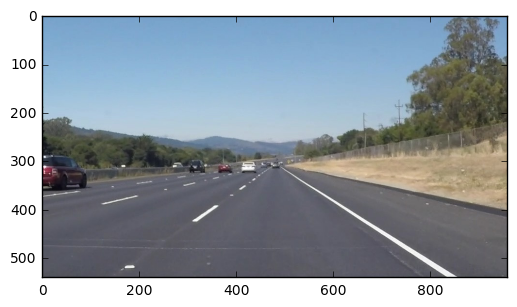

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [69]:
def manage_yellow(image):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # define range of yellow color in HSV
    lower_yellow = np.array([20,100,200])
    upper_yellow = np.array([30,255,255])

    # Threshold the HSV image to get only yellow colors
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    return mask

In [254]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255,0,0], thickness=2, draw_point=0):
    """
    function draw_lines takes lines (segments) detected during hough transformation,
    filter them so to retain just lines with absolute value of curve more than 0.5
    and based on the sign of the carve assigns the tops of the lines to the left and
    right lane
    sub function draw_points visualizes tops of the lines (segments)
    I'm using polyfit function from numpy to make a linear extrapolation of the lane
    curve using the tops
    
    """
    def draw_points():
        #draw points of detected lines
        for i in range(len(left_x)):
            cv2.circle(img,(left_x[i],left_y[i]), 10, (0,0,255), -1)
        for i in range(len(right_x)):
            cv2.circle(img,(right_x[i],right_y[i]), 10, (0,255,0), -1)    
        
    left_x = []
    left_y = []
    
    right_x = []
    right_y = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (y2-y1)/(x2-x1) > 0.5 or (y2-y1)/(x2-x1) < -0.5:
                if (y2-y1)/(x2-x1)<0 and x1<img.shape[1]/2:
                    left_x.append(x1)
                    left_x.append(x2)
                    left_y.append(y1)
                    left_y.append(y2)
                elif (y2-y1)/(x2-x1)>=0 and x1>img.shape[1]/2:
                    right_x.append(x1)
                    right_x.append(x2)
                    right_y.append(y1)
                    right_y.append(y2)
      
    if draw_point==1:
        draw_points()
    if left_x and left_y:
        left = np.poly1d(np.polyfit(left_x,left_y,1))
        left_x_final = []
        left_y_final = []

        for i in range(int(0.12*img.shape[1]),int(0.46*img.shape[1])):
            if (left(i)<img.shape[0] and left(i)>0):
                left_x_final.append(i)
                left_y_final.append(int(left(i)))

        for i in range(len(left_x_final)-1):
            cv2.line(img, (left_x_final[i], left_y_final[i]), \
                     (left_x_final[i+1], left_y_final[i+1]), color, 5)
    
    if right_x and right_y:    
        right = np.poly1d(np.polyfit(right_x,right_y,1))
        right_x_final = []
        right_y_final = []

        for i in range(int(0.56*img.shape[1]), int(0.95*img.shape[1])):
            if (right(i)<img.shape[0] and right(i)>0):
                right_x_final.append(i)
                right_y_final.append(int(right(i)))

        for i in range(len(right_x_final)-1):
            cv2.line(img, (right_x_final[i], right_y_final[i]), \
                     (right_x_final[i+1], right_y_final[i+1]), color, 5)

        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines,thickness=10,draw_point=0)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [255]:
import os
test_images = os.listdir("test_images/")
if '.DS_Store' in test_images:
    test_images.remove('.DS_Store')

Two lines below disable scrolling of the output cell

In [256]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

Here is my pipeline.

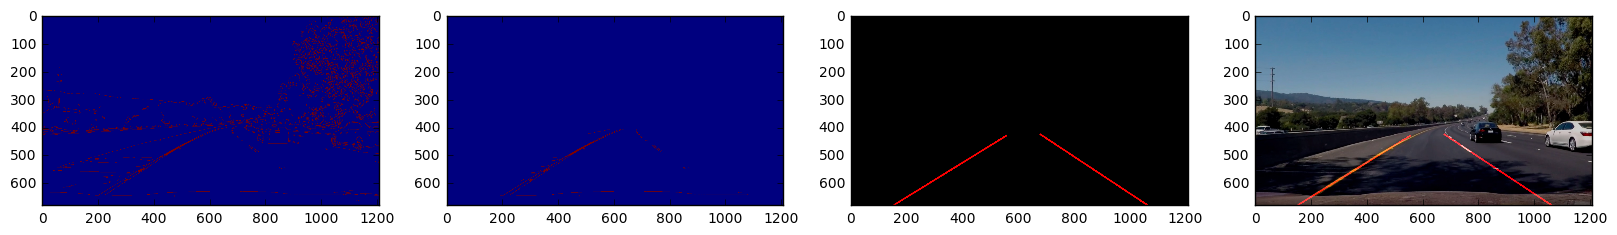

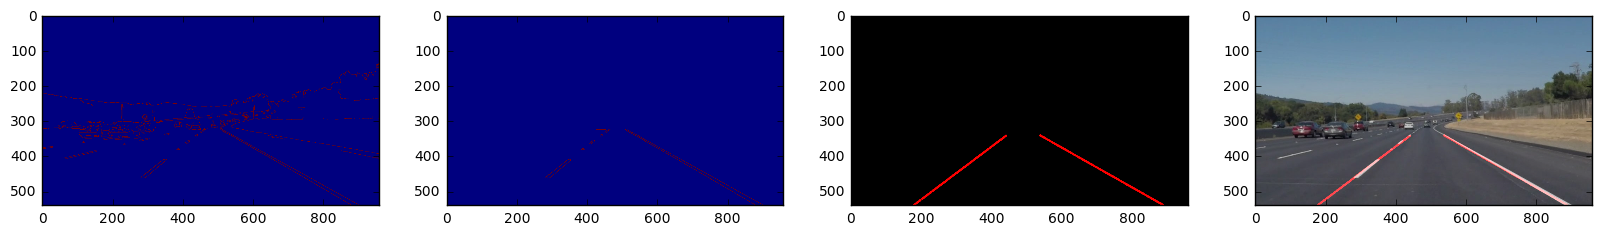

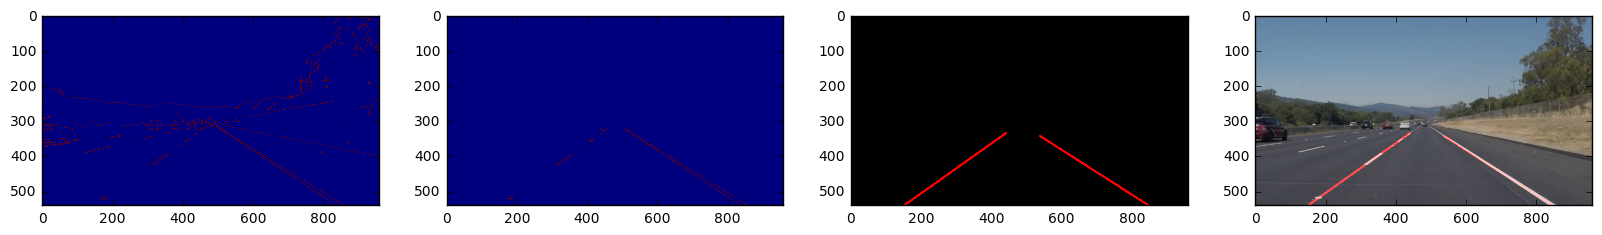

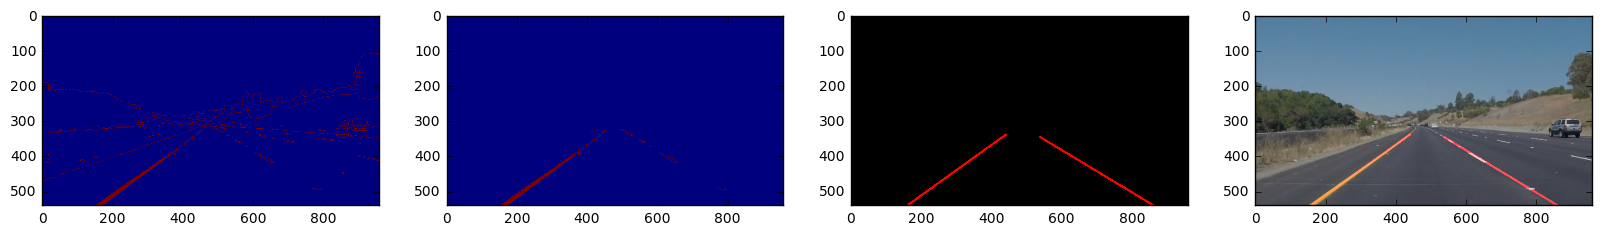

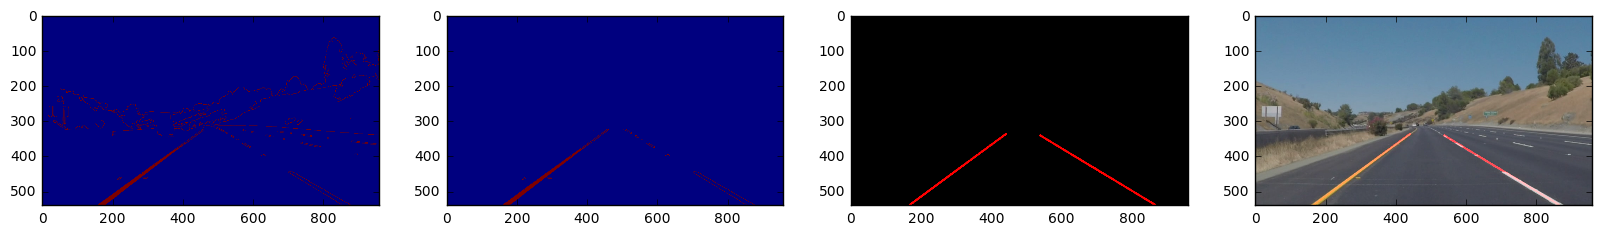

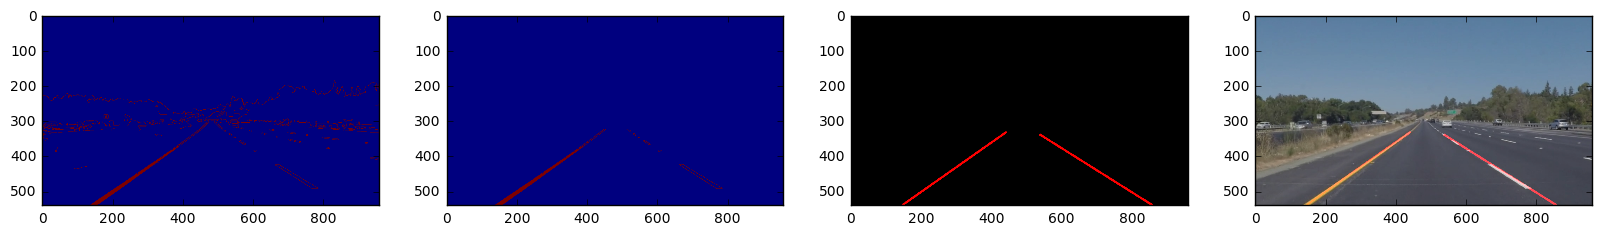

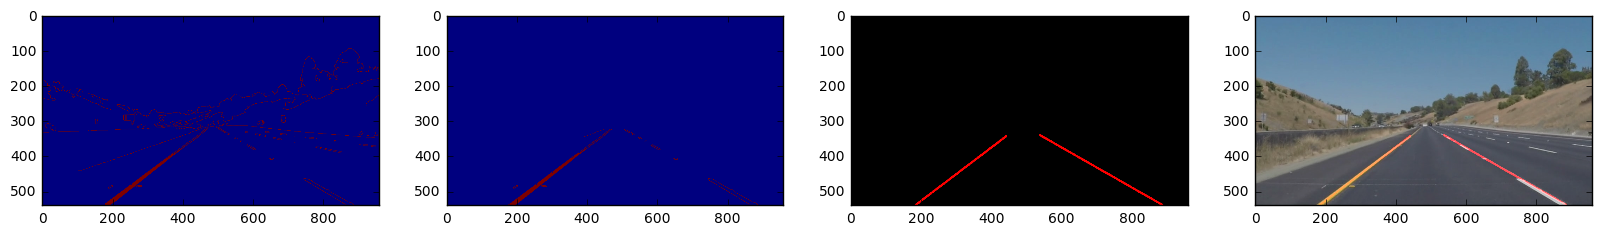

In [257]:
def image_processing(image, draw_mask_v = 0):
    """
    function image_processing is a pipeline of image transformations:
    1) transformation to grayscale
    2) image smoothing using Gaussian filter
    3) edge detection using Canny detector
    3*) adding yellow lanes to edges image
    4) excluding everything out of region of interest's polygon
    5) applying hough transformation
    6) combining initial image with results
    """
    def draw_mask():
        #visualizing mask polygon
        cv2.line(image, A, B,[255, 0, 0], 5)
        cv2.line(image, B, C, [255, 0, 0], 5)
        cv2.line(image, C, D, [255, 0, 0], 5)
        cv2.line(image, D, A, [255, 0, 0], 5)

    gray = grayscale(image)
    gray_blur = gaussian_blur(gray, 5)
    edges = canny(gray_blur, 50, 150)
    edges = cv2.bitwise_or(edges, manage_yellow(image)) 

    imshape = image.shape

    A = (int(0.11*imshape[1]), imshape[0])
    B = (int(0.44*imshape[1]), int(0.6*imshape[0]))
    C = (int(0.56*imshape[1]), int(0.6*imshape[0]))
    D = (int(0.95*imshape[1]), imshape[0])
    vertices = np.array([[A, B, C, D]], dtype=np.int32)

    if draw_mask_v == 1:
        draw_mask()

    canny_img = region_of_interest(edges, vertices)

    rho = 2
    theta = np.pi / 180
    threshold = 70
    min_line_len = 2
    max_line_gap = 2

    hough = hough_lines(canny_img, rho, theta, threshold, min_line_len, max_line_gap)
    final = weighted_img(hough, image, α=0.8, β=1., λ=0.)

    return edges, canny_img, hough, final

for name in test_images:
    image = mpimg.imread('test_images/'+name)
    edges, canny_img, hough, final = image_processing(image)
        
    f = plt.figure(figsize=(20,10))

    f.add_subplot(1, 4, 1)
    plt.imshow(np.asarray(edges))

    f.add_subplot(1, 4, 2)
    plt.imshow(np.asarray(canny_img))

    f.add_subplot(1, 4, 3)
    plt.imshow(np.asarray(hough))

    f.add_subplot(1,4,4)
    plt.imshow(np.asarray(final))

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [258]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [259]:
from moviepy.editor import VideoFileClip
clip1= VideoFileClip("solidYellowLeft.mp4")

In [260]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    _,_,_, result = image_processing(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [261]:
from moviepy.editor import VideoFileClip
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:14<00:00, 15.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 14.2 s, sys: 1.01 s, total: 15.3 s
Wall time: 15.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [262]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [263]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:47<00:00, 14.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 45.7 s, sys: 3.28 s, total: 49 s
Wall time: 48.5 s


In [264]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

During this project I've applied to edge detection and hough transformation in order to detect the lanes. To be able to detect the lanes on the image with multiple edges, the special polygon (which we think should include just the road in from of the car) was applied and I was looking for the lanes just inside this polygon. To make the results of the current project even more robust, I might use additional (smaller) polygon inside the first one to avoid noise colors on the road in front.

However, in perspective I would check how to detect interesting for us objects without limiting the image just to the polygon. We might want/need to detect next lines, cars, signs on the road, etc which makes the usage of region of interest non efficient.

I've faced with two colors of lanes: white and yellow. To be able to detect yellow lanes, HSV (hue, saturation, value) transformation was applied. It let me determine the low and high ranges for yellow color and filter everything on the image out of this color.

If the car enters the part of the road without lanes, current algorithm won't be able to estimate the lines based on the history or probable lane wide. Lane estimation might be used as a next step in the algorithm improvement.

I've used linear extrapolation of the lanes to estimate the lane curve based on the determined points. This approach works ok in front of the car. But to estimates curves (especially when the road turns), advanced algorithms of road lane function should be applied.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [265]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:31<00:00,  5.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 35.6 s, sys: 2.29 s, total: 37.8 s
Wall time: 33.7 s


In [266]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

As mentioned in the reflection section, more sophisticated lane curve function required to make the result accurate.
The robustness of the algorithm on the sections without lane line is required